In [137]:
# trf_collector.py
# Avery Krieger 11/2022

# argumenmts: [1] date (yyyy-mm-dd); [2] series_number; [3] roi_set_name
# implementation: save_strfs.py 2022-03-17 1 roi_set_postfrom visanalysis.analysis import imaging_data, shared_analysis

# this allows you to edit src code and run 
# (the alternative is to restart the kernel EVERY time you make a change to src...BAD)
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import matplotlib.patches as mpatches  # for the legend patches
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from scipy import interpolate
from two_photon_analysis import medulla_analysis as ma
from visanalysis.analysis import imaging_data, shared_analysis

import pyfiglet

#Initialize relevant variables
experiment_file_directory_stem = "/Volumes/ROG2TBAK/data/bruker/"
experiment_file_directory = "/Volumes/ROG2TBAK/data/bruker/20221027"

# create save directory
save_directory = "/Volumes/ROG2TBAK/data/bruker/trfs/"
print(f'Save directory is {save_directory}')
Path(save_directory).mkdir(exist_ok=True)

filter_length = 3
dff = False
savefig = True

# Set ideal frame rate
ideal_frame_rate = 120 #Hz
filter_size = filter_length*ideal_frame_rate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Save directory is /Volumes/ROG2TBAK/data/bruker/trfs/


# Da Functions below

In [135]:
# SEM Plot for single ROIs!
def plotSingleTRFComparison(
                  nopto_trf, nopto_sem_plus, nopto_sem_minus,
                  yopto_trf, yopto_sem_plus, yopto_sem_minus,
                  filter_len, ideal_frame_rate = 120, savefig = False,
                  roi_set = 'arb_roi',
                 ):
    fh, ax = plt.subplots(1, 1, figsize=(20, 10))
    #time = np.arange(0, roi_trfs.shape[1])
    filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)

    ax.plot(filter_time, yopto_trf, color="r")
    ax.fill_between(filter_time, yopto_sem_plus, yopto_sem_minus, color="r", alpha=0.4)
    ax.plot(filter_time, nopto_trf, color="g")
    ax.fill_between(filter_time, nopto_sem_plus, nopto_sem_minus, color="g", alpha=0.4)
    ax.axhline(y=0, color="k", alpha=0.5)
    red_patch = mpatches.Patch(color="red", label="Opto Condition")
    green_patch = mpatches.Patch(color="green", label="No Opto Condition")

    ax.legend(handles=[green_patch, red_patch], fontsize=20)
    ax.set_title(
                 f"{roi_set} Temporal Receptive Field for averaged ROIs | Filter Length: {filter_length}",
                 fontsize=25,
    )
    ax.set_xlabel("Time (s)", fontweight="bold", fontsize=13)
    ax.grid(True)

    if savefig == True:
        fh.savefig(
            save_directory
            + str(roi_set)
            + ".Cross-ROI.TemporalReceptiveField."
            + "FilterLength="
            + str(filter_length)
            + ".pdf",
            dpi=300,
        )

# SEM Plot for multiple ROIs!
def plotMultipleTRFComparisons(
                               nopto_mean_trf, nopto_sem_plus, nopto_sem_minus,
                               yopto_mean_trf, yopto_sem_plus, yopto_sem_minus,
                               filter_len, ideal_frame_rate = 120, savefig = False,
                               roi_set = 'arb_roi'
                              ):
    roi_count = nopto_mean_trf.shape[0]

    fh, ax = plt.subplots(roi_count, 1, figsize=(10,roi_count*5))
    #time = np.arange(0, roi_trfs.shape[1])
    filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)
    for roi_ind in range(0, roi_count):
        ax[roi_ind].plot(filter_time, yopto_mean_trf[roi_ind], color="r")
        ax[roi_ind].fill_between(filter_time, yopto_sem_plus[roi_ind], yopto_sem_minus[roi_ind], color="r", alpha=0.4)
        ax[roi_ind].plot(filter_time, nopto_mean_trf[roi_ind], color="g")
        ax[roi_ind].fill_between(filter_time, nopto_sem_plus[roi_ind], nopto_sem_minus[roi_ind], color="g", alpha=0.4)
        ax[roi_ind].axhline(y=0, color="k", alpha=0.5)
        red_patch = mpatches.Patch(color="red", label="Opto Condition")
        green_patch = mpatches.Patch(color="green", label="No Opto Condition")

        ax[roi_ind].legend(handles=[green_patch, red_patch], fontsize=12)
        ax[roi_ind].set_title(f'ROI Set: {roi_set} | Individual TRF for ROI: {roi_ind}', fontsize=10)

        ax[roi_ind].set_xlabel("Time (s)", fontsize=11)
        ax[roi_ind].grid(True)
        
    if savefig == True:
        fh.savefig(
            save_directory
            + str(roi_set)
            + ".Each-ROI.TemporalReceptiveField."
            + "FilterLength-"
            + str(filter_len)
            + ".pdf",
            dpi=300,
        )

def trfDiffCalc(nopto_trf, nopto_sem_plus, nopto_sem_minus,
             yopto_trf, yopto_sem_plus, yopto_sem_minus,
            ):
    trf_diff = yopto_trf - nopto_trf
    trf_sem_plus_diff = yopto_sem_plus - nopto_sem_plus
    trf_sem_minus_diff = yopto_sem_minus - nopto_sem_minus
    
    return trf_diff, trf_sem_plus_diff, trf_sem_minus_diff

# SEM Diff plot for single ROIs
def plotSingleTRFDiff(
                  trf_diff, trf_sem_plus_diff, trf_sem_minus_diff,
                  filter_len, ideal_frame_rate = 120, savefig = False,
                  roi_set = 'arb_roi',
                 ):
    fh, ax = plt.subplots(1, 1, figsize=(20, 10))
    #time = np.arange(0, roi_trfs.shape[1])
    filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)

    ax.plot(filter_time, trf_diff, color="r")
    ax.fill_between(filter_time, trf_sem_plus_diff, trf_sem_minus_diff, color="r", alpha=0.4)
    
    ax.axhline(y=0, color="k", alpha=0.5)
    ax.set_title(
                 f"{roi_set} Temporal Receptive Field Diff for averaged ROIs | Filter Length: {filter_length}",
                 fontsize=25,
    )
    ax.set_xlabel("Time (s)", fontweight="bold", fontsize=13)
    ax.grid(True)

    if savefig == True:
        fh.savefig(
            save_directory
            + "Diff."
            + str(roi_set)
            + ".Cross-ROI.TemporalReceptiveField."
            + "FilterLength="
            + str(filter_length)
            + ".pdf",
            dpi=300,
        )
        
# SEM Diff plot for multiple ROIs!
def plotMultipleTRFDiffs(
                               nopto_mean_trf, nopto_sem_plus, nopto_sem_minus,
                               yopto_mean_trf, yopto_sem_plus, yopto_sem_minus,
                               filter_len, ideal_frame_rate = 120, savefig = False,
                               roi_set = 'arb_roi'
                              ):
    roi_count = nopto_mean_trf.shape[0]

    fh, ax = plt.subplots(roi_count, 1, figsize=(10,roi_count*5))
    #time = np.arange(0, roi_trfs.shape[1])
    filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)
    for roi_ind in range(0, roi_count):
        # calc diff
        trf_diff, trf_sem_plus_diff, trf_sem_minus_diff = trfDiffCalc(
                                                              nopto_mean_trf[roi_ind], 
                                                              nopto_sem_plus[roi_ind], 
                                                              nopto_sem_minus[roi_ind],
                                                              yopto_mean_trf[roi_ind], 
                                                              yopto_sem_plus[roi_ind], 
                                                              yopto_sem_minus[roi_ind],
                                                              )
        
        ax[roi_ind].plot(filter_time, trf_diff, color="r")
        ax[roi_ind].fill_between(filter_time, trf_sem_plus_diff, trf_sem_minus_diff, color="r", alpha=0.4)
        ax[roi_ind].axhline(y=0, color="k", alpha=0.5)
        ax[roi_ind].set_title(f'Opto-No Opto ROI Set: {roi_set} | Individual TRF for ROI: {roi_ind}', fontsize=10)
        ax[roi_ind].set_xlabel("Time (s)", fontsize=11)
        ax[roi_ind].grid(True)
        
    if savefig == True:
        fh.savefig(
            save_directory
            + "Diff."
            + str(roi_set)
            + ".Each-ROI.TemporalReceptiveField"
            + "FilterLength-"
            + str(filter_length)
            + ".pdf",
            dpi=300,
        )

## Sets of experiments available

In [122]:
# Mi1 Experiments - Single ROI
#mi1_exp0_prox = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_proximal"]]
#mi1_exp0_medi = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_medial"]]
#mi1_exp0_dist = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_distal"]]
# Until we motion correct, this one sucks ^^
mi1_exp1_prox = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_proximal"]]
mi1_exp1_medi = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_medial"]]
mi1_exp1_dist = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "2", "Mi1_distal"]]

mi1_exp2_prox = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_proximal"]]
mi1_exp2_medi = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_medial"]]
mi1_exp2_dist = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "5", "Mi1_distal"]]

mi1_exp3_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_proximal"]]
mi1_exp3_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_medial"]]
mi1_exp3_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "1", "Mi1_distal"]]

mi1_exp4_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_proximal"]]
mi1_exp4_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_medial"]]
mi1_exp4_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_distal"]]

mi1_exp5_prox = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_proximal"]]
mi1_exp5_medi = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_medial"]]
mi1_exp5_dist = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_distal"]]

expts_prox = np.concatenate(
                       (#mi1_exp0_prox, 
                        mi1_exp1_prox, mi1_exp2_prox,
                        mi1_exp3_prox, mi1_exp4_prox, mi1_exp5_prox), 
                        axis = 0,
                      )
expts_medi = np.concatenate(
                       (#mi1_exp0_medi, 
                        mi1_exp1_medi, mi1_exp2_medi,
                        mi1_exp3_medi, mi1_exp4_medi, mi1_exp5_medi), 
                        axis = 0,
                      )
expts_dist = np.concatenate(
                       (#mi1_exp0_dist, 
                        mi1_exp1_dist, mi1_exp2_dist,
                        mi1_exp3_dist, mi1_exp4_dist, mi1_exp5_dist), 
                        axis = 0,
                      )

# Mi1 Experiments - Multiple ROIs
mi1_exp0 = [["/Volumes/ROG2TBAK/data/bruker/20221025", "2022-10-25", "1", "Mi1_proximal_mixed"]]
mi1_exp1 = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "3", "Mi1_proximal_mixed"]]
mi1_exp2 = [["/Volumes/ROG2TBAK/data/bruker/20221027", "2022-10-27", "5", "Mi1_proximal_mixed"]]

# L2 Experiments
l2_exp0 = [["/Volumes/ROG2TBAK/data/bruker/20221101", "2022-11-01", "2", "L2_modulated"]]
l2_exp1 = [["/Volumes/ROG2TBAK/data/bruker/20221101", "2022-11-01", "6", "L2_modulated"]]

# Choose which experiment and ROI set to run below:

In [138]:
neuron_class = 'Mi1'
roi_set = 'prox'
single_roi = True


if neuron_class == 'Mi1':
    if single_roi == True:
        if roi_set == 'prox':
            expts = expts_prox
            ascii_banner_start = pyfiglet.figlet_format(f"Loaded Mi1 single-ROI data: Proximal")
        elif roi_set == 'medi':
            expts = expts_medi
            ascii_banner_start = pyfiglet.figlet_format(f"Loaded Mi1 single-ROI data: Medial")
        elif roi_set == 'dist':
            expts = expts_dist
            ascii_banner_start = pyfiglet.figlet_format(f"Loaded Mi1 single-ROI data: Distal")
    elif single_roi == False:
        expts = np.concatenate(
                               (mi1_exp1, mi1_exp2), 
                                axis = 0
                              )

elif neuron_class == 'L2':
    single_roi = True
    expts = np.concatenate(
                           (l2_exp0, l2_exp1), 
                            axis = 0
                          )
    ascii_banner_start = pyfiglet.figlet_format(f"Loaded L2 single-ROI data")
    
print(*["\n"+'-'*82 for _ in range(4)],sep="")
print(ascii_banner_start)
print(*[*["\n"+'-'*82]*4],sep="")


# Running the trfMaker function from medulla_analysis across experiments
# initialize all the arrays
single_roi = False
if single_roi == True:
    roi_mean_trf = nopto_mean_trf = nopto_sem_plus = nopto_sem_minus = \
    yopto_mean_trf = yopto_sem_plus = yopto_sem_minus = np.empty(shape=[0, filter_size])

elif single_roi == False: 
    roi_mean_trf = np.empty(shape=[0, filter_size])
    nopto_mean_trf = np.empty(shape=[0, filter_size])
    nopto_sem_plus = np.empty(shape=[0, filter_size])
    nopto_sem_minus = np.empty(shape=[0, filter_size])
    yopto_mean_trf = np.empty(shape=[0, filter_size])
    yopto_sem_plus = np.empty(shape=[0, filter_size])
    yopto_sem_minus = np.empty(shape=[0, filter_size])

ascii_banner_start = pyfiglet.figlet_format("Temporal Receptive Field Generator")
print(*["\n"+'-'*82 for _ in range(4)],sep="")
print(ascii_banner_start)
print(*[*["\n"+'-'*82]*4],sep="")

for exp in range(0, len(expts)):
    print(f'\n\n-------Started Experiment {exp+1} of {len(expts)}!-------\n')
    
    (exp_roi_mean_trf, exp_nopto_mean_trf, exp_nopto_sem_plus, exp_nopto_sem_minus, 
    exp_yopto_mean_trf, exp_yopto_sem_plus, exp_yopto_sem_minus) = \
    ma.trfMaker(expts[exp, 0], expts[exp, 1], expts[exp, 2], expts[exp, 3], 
             filter_length, dff, savefig
            )
    
    # append to big array
    print(f'the shape of roi_mean_trf is {roi_mean_trf.shape}')
    print(f'the shape of exp_roi_mean_trf is {exp_roi_mean_trf.shape}')
    print(f'the shape of nopto_sem_plus is {nopto_sem_plus.shape}')
    print(f'the shape of exp_nopto_sem_plus is {exp_nopto_sem_plus.shape}')
    if single_roi == True:
        roi_mean_trf = np.append(roi_mean_trf, np.squeeze(exp_roi_mean_trf), axis = 0)
        nopto_mean_trf = np.append(nopto_mean_trf, np.squeeze(exp_nopto_mean_trf), axis = 0)           
        nopto_sem_plus = np.append(nopto_sem_plus, np.squeeze(exp_nopto_sem_plus), axis = 0)
        nopto_sem_minus = np.append(nopto_sem_minus, np.squeeze(exp_nopto_sem_minus), axis = 0)
        yopto_mean_trf = np.append(yopto_mean_trf, np.squeeze(exp_yopto_mean_trf), axis = 0)
        yopto_sem_plus = np.append(yopto_sem_plus, np.squeeze(exp_yopto_sem_plus), axis = 0)
        yopto_sem_minus = np.append(yopto_sem_minus, np.squeeze(exp_yopto_sem_minus), axis = 0)
    elif single_roi == False:
        roi_mean_trf = np.append(roi_mean_trf, exp_roi_mean_trf, axis = 0)
        print(f'the new shape of roi_mean_trf is {roi_mean_trf.shape}')
        print(f'the new shape of exp_roi_mean_trf is {exp_roi_mean_trf.shape}')
        nopto_mean_trf = np.append(nopto_mean_trf, exp_nopto_mean_trf, axis = 0)           
        nopto_sem_plus = np.append(nopto_sem_plus, exp_nopto_sem_plus, axis = 0)
        nopto_sem_minus = np.append(nopto_sem_minus, exp_nopto_sem_minus, axis = 0)
        yopto_mean_trf = np.append(yopto_mean_trf, exp_yopto_mean_trf, axis = 0)
        yopto_sem_plus = np.append(yopto_sem_plus, exp_yopto_sem_plus, axis = 0)
        yopto_sem_minus = np.append(yopto_sem_minus, exp_yopto_sem_minus, axis = 0)

# Run function to average across ROIs
(across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus, 
 across_roi_yopto_trf,across_roi_yopto_sem_plus, across_roi_yopto_sem_minus) = \
 ma.avgAcrossROIs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus, 
               yopto_mean_trf, yopto_sem_plus, yopto_sem_minus)

print(*["\n"+'-'*82 for _ in range(2)],sep="")
print('Averaged Across ROIs')

ascii_banner_end = pyfiglet.figlet_format("FINITO")
print(*["\n"+'-'*82 for _ in range(4)],sep="")
print(ascii_banner_end)
print(*[*["\n"+'-'*82]*4],sep="")


----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
 _                    _          _   __  __ _ _ 
| |    ___   __ _  __| | ___  __| | |  \/  (_) |
| |   / _ \ / _` |/ _` |/ _ \/ _` | | |\/| | | |
| |__| (_) | (_| | (_| |  __/ (_| | | |  | | | |
|_____\___/ \__,_|\__,_|\___|\__,_| |_|  |_|_|_|
                                                
     _             _            ____   ___ ___       _       _          
 ___(_)_ __   __ _| | ___      |  _ \ / _ \_ _|   __| | __ _| |_ __ _ _ 
/ __| | '_ \ / _` | |/ _ \_____| |_) | | | | |   / _` |/ _` | __/ _` (_)
\__ \ | | | | (_| | |  __/_____|  _ <| |_| | |  | (_| | (_| | || (_| |_ 
|___/_|_| |_|\__, |_|\___|     |_| \_\\___/___|  \__,_|\__,_|\__\__,_(_)
        

...Starting Trial 100 of 150...
...Starting Trial 110 of 150...
...Starting Trial 120 of 150...
...Starting Trial 130 of 150...
...Starting Trial 140 of 150...

-------
DONE!
-------

the shape of roi_mean_trf is (4, 360)
the shape of exp_roi_mean_trf is (1, 360)
the shape of nopto_sem_plus is (4, 360)
the shape of exp_nopto_sem_plus is (1, 360)
the new shape of roi_mean_trf is (5, 360)
the new shape of exp_roi_mean_trf is (1, 360)

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Averaged Across ROIs

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
 _____ ___ _   _ ___ _____ ___  
|  ___|_ _

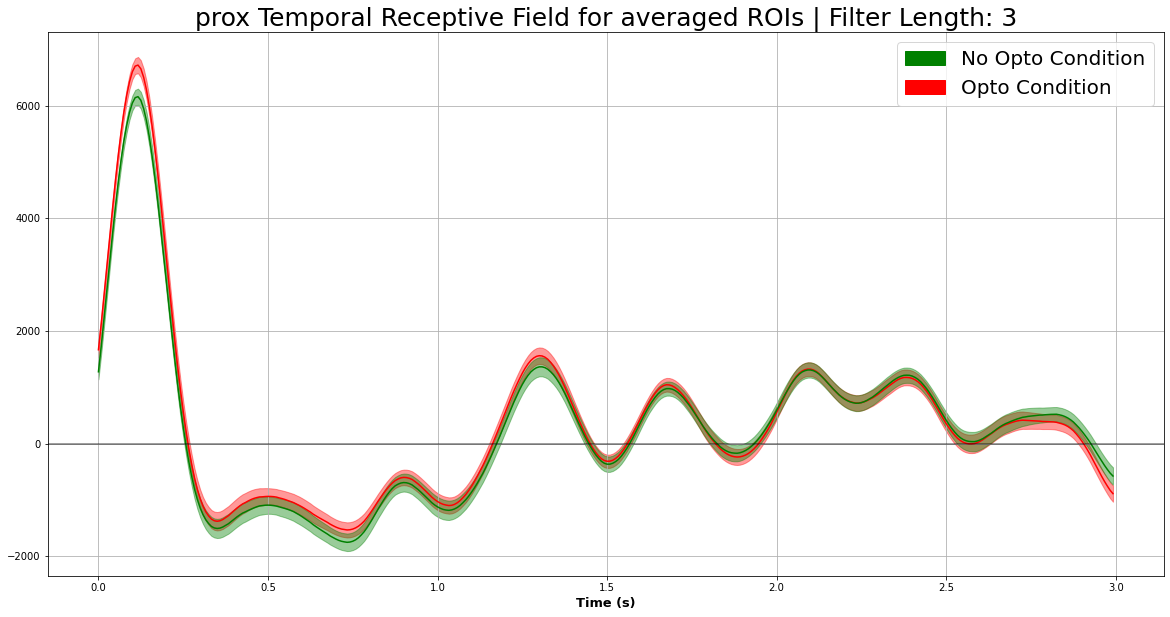

In [139]:
plotSingleTRFComparison(
                  across_roi_nopto_trf, across_roi_nopto_sem_plus, across_roi_nopto_sem_minus,
                  across_roi_yopto_trf, across_roi_yopto_sem_plus, across_roi_yopto_sem_minus,
                  filter_len = filter_size, savefig = True, roi_set = roi_set,
                 )

In [140]:
trf_diff, trf_sem_plus_diff, trf_sem_minus_diff = trfDiffCalc(
                                                              across_roi_nopto_trf, 
                                                              across_roi_nopto_sem_plus, 
                                                              across_roi_nopto_sem_minus,
                                                              across_roi_yopto_trf, 
                                                              across_roi_yopto_sem_plus, 
                                                              across_roi_yopto_sem_minus,
                                                              )

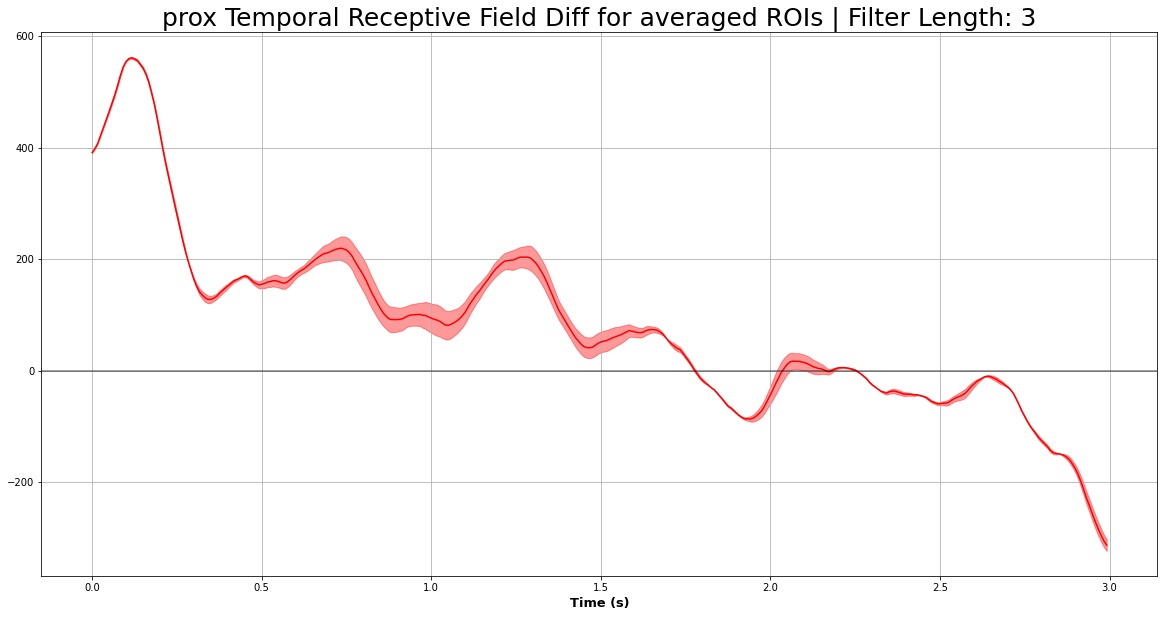

In [141]:
plotSingleTRFDiff(
                        trf_diff, trf_sem_plus_diff, trf_sem_minus_diff,
                        filter_len = filter_size, savefig = True, roi_set = roi_set,
                       )

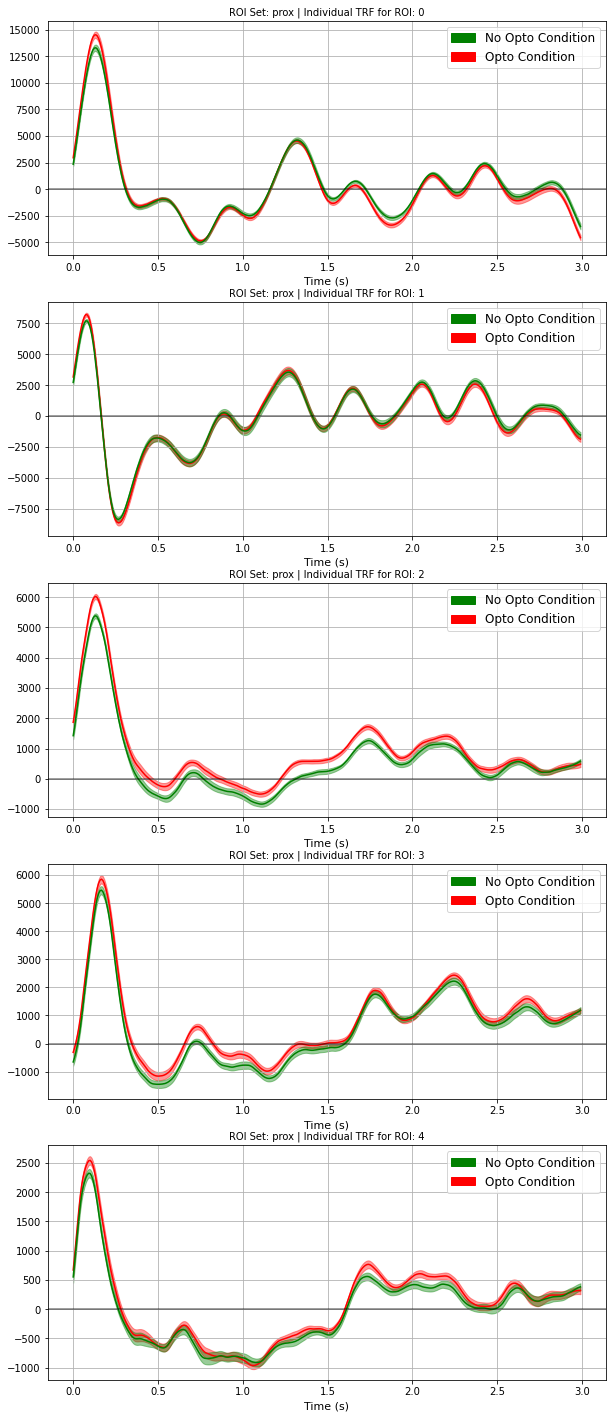

In [142]:
plotMultipleTRFComparisons(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus,
                           yopto_mean_trf, yopto_sem_plus, yopto_sem_minus,
                           filter_len = filter_size, ideal_frame_rate = 120, 
                           savefig = True, roi_set = roi_set,)

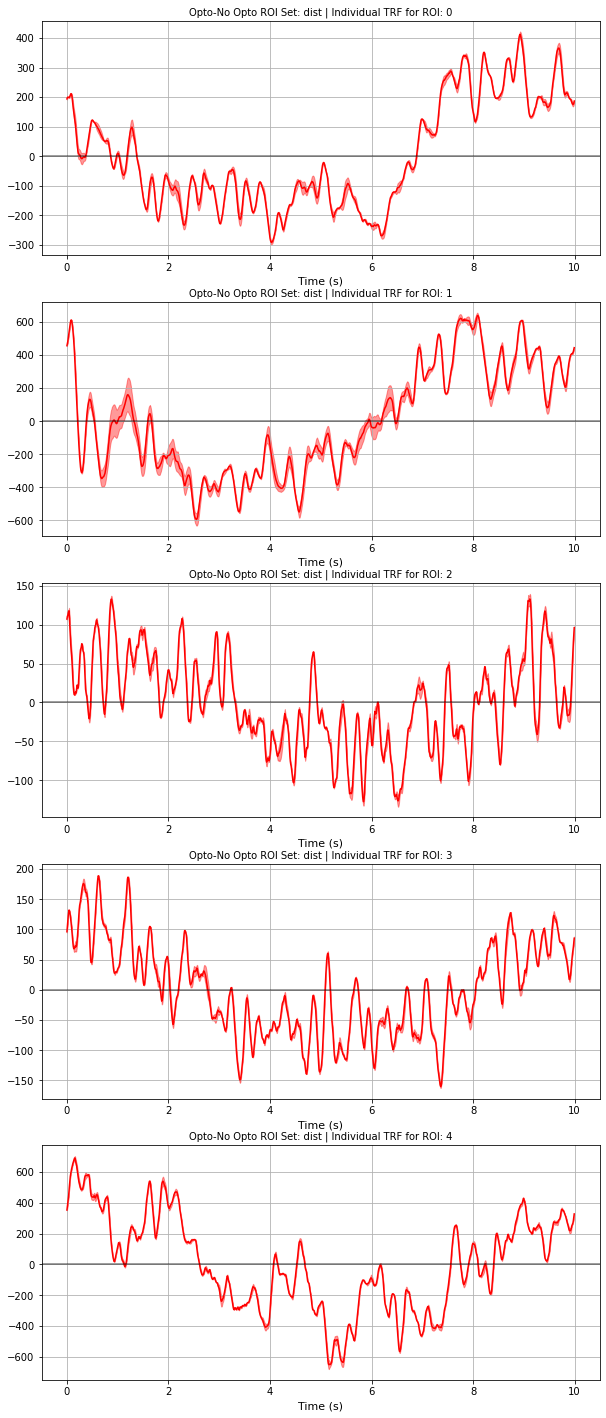

In [136]:
plotMultipleTRFDiffs(nopto_mean_trf, nopto_sem_plus, nopto_sem_minus,
                           yopto_mean_trf, yopto_sem_plus, yopto_sem_minus,
                           filter_len = filter_size, ideal_frame_rate = 120, 
                           savefig = True, roi_set = roi_set,)